# Daten als Produkt: Wert vs. Aufwand
## Eine empirische Analyse am Beispiel eines Online-Retailers

**Kurs:** WWI2023F – Data Management Fundamentals \
**Prüfer:** Andreas Buckenhofer \
**Student:** Raphael Kach \
**Matrikelnummer:** 5508411

Das Notebook für dieses Thema kann unter Google Colab direkt ausgeführt werden.

[![Notebook in Colab öffnen](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/raphaelkach/Daten_als_Produkt/blob/main/Daten_als_Produkt.ipynb)

In [1]:
# Alle benötigten Pakete werden installiert
!pip install -q "duckdb>=0.9.0" "ucimlrepo>=0.0.3" certifi "pandas>=1.5.0" "numpy>=1.23.0" "matplotlib>=3.6.0" "seaborn>=0.12.0" "scipy>=1.9.0"

# SSL-Zertifikate fixen (für lokale Ausführung auf macOS)
import ssl, certifi, urllib.request
ssl_ctx = ssl.create_default_context(cafile=certifi.where())
urllib.request.install_opener(urllib.request.build_opener(urllib.request.HTTPSHandler(context=ssl_ctx)))

# Standardbibliotheken
import duckdb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from scipy.stats import spearmanr
from ucimlrepo import fetch_ucirepo
from matplotlib.patches import Patch
from matplotlib.patches import Circle as MplCircle
from matplotlib.lines import Line2D
from matplotlib.offsetbox import AnchoredOffsetbox, VPacker, HPacker, TextArea, DrawingArea
import warnings
warnings.filterwarnings('ignore')


# IBCS-konformes Visualisierungsstil-Setup (International Business Communication Standards, Hichert)
# Regeln: SUCCESS – Say, Unify, Condense, Check, Express, Simplify, Structure
plt.rcParams.update({
    'figure.figsize': (12, 6),
    'figure.dpi': 150,
    'figure.facecolor': 'white',
    'axes.facecolor': 'white',
    'axes.edgecolor': '#CCCCCC',
    'axes.grid': True,
    'axes.grid.axis': 'y',
    'grid.color': '#E8E8E8',
    'grid.linewidth': 0.5,
    'grid.alpha': 0.7,
    'font.size': 11,
    'font.family': 'sans-serif',
    'axes.titlesize': 13,
    'axes.titleweight': 'bold',
    'axes.labelsize': 11,
    'axes.spines.top': False,
    'axes.spines.right': False,
    'axes.spines.left': True,
    'axes.spines.bottom': True,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'legend.frameon': False,
})
sns.set_style("white")

# IBCS-Farbpalette (Hichert-konform)
# Grundregel: Graustufen als Basis, Farbe nur für Hervorhebung
IBCS = {
    'actual': '#404040',        # Ist-Werte (dunkelgrau, solide)
    'previous': '#808080',      # Vergleichswerte (mittelgrau)
    'plan': '#B0B0B0',          # Plan/Forecast (hellgrau)
    'background': '#D9D9D9',    # Hintergrund-Referenz
    'highlight': '#1565C0',     # Hervorhebung positiv (blau)
    'highlight_neg': '#C62828', # Hervorhebung negativ (rot)
    'highlight_pos': '#2E7D32', # Hervorhebung positiv (grün)
    'gridline': '#E8E8E8',     # Gitternetzlinien
    'annotation': '#404040',   # Beschriftungen
}

# Segmentfarben: Champions hervorgehoben, Rest in Graustufen
SEGMENT_COLORS = {
    'Champions': IBCS['highlight'],     # Blau – Key Segment
    'Loyal': IBCS['actual'],            # Dunkelgrau
    'Promising': '#606060',           # Mittel-dunkelgrau
    'At Risk': IBCS['previous'],        # Mittelgrau
    'Lost': IBCS['plan'],               # Hellgrau
}

# Farben für VB-Konzeptdiagramme (nicht-IBCS, da keine Datencharts)
COLORS = {
    'primary': '#4C72B0', 'secondary': '#DD8452', 'success': '#55A868',
    'warning': '#C44E52', 'accent': '#8172B3',
}

---
## 1. Einleitung
Die Online-Handelsbranche zählt zu den datenintensivsten Wirtschaftsbereichen. Jeder Klick, jede Transaktion oder jede Retoure erzeugt Datenpunkte, welche ein umfassendes Verständnis des Kundenverhaltens oder der Kundenbedürfnisse ermöglichen können. Angesichts kontinuierlich wachsender Datenvolumina und leistungsfähiger Analysewerkzeuge besteht in vielen Unternehmen die Annahme, dass mehr Daten automatisch zu besseren Entscheidungen führen [5]. Diese Annahme findet bei näherer Betrachtung keine Bestätigung. Dieser Trugschluss führt in der Praxis meist zu großen Datenpipelines und einem Governance-Overhead [10], ohne dass der Mehrwert proportional mitwächst.

Durch die vorliegende Arbeit wird dieser Sachverhalt am Beispiel eines realen Online-Händlers untersucht. Grundlage hierfür ist der UCI Online Retail Datensatz mit 541.909 Transaktionen eines britischen Geschenkartikelhändlers [4]. Empirisch wird gezeigt, dass ein minimales Datenset bestehend aus drei Kennzahlen (Recency, Frequency und Monetary) [8] ausreicht, um drei messbare Business-Use-Cases zu bedienen. Diese Kennzahlen lassen sich direkt aus den vorhandenen Transaktionsdaten herleiten, ohne zusätzlichen Erhebungsaufwand zu erfordern oder externe Datenquellen zu nutzen. Aus diesen lassen sich dann High-Value-Kunden identifizieren, Kundenabwanderungen frühzeitig erkennen sowie Cross-Selling-Potenziale ableiten.

Der Scope umfasst das RFM-basierte Kunden-Scoring, eine regelbasierte Churn-Erkennung und eine einfache Warenkorbanalyse auf Basis von acht Rohdatenspalten des UCI-Datensatzes [12]. Dabei werden Echtzeit-Empfehlungssysteme, Deep-Learning-Modelle sowie die Anreicherung mit externen Datenquellen ausgeklammert. Das Ziel besteht darin, den Nachweis zu erbringen, dass eine gezielte Datenselektion mehr Wert schafft als eine undifferenzierte Datensammlung.

---
## 2. Theoretische Grundlagen
Um diese These theoretisch einzuordnen und die nachfolgende empirische Analyse zu fundieren, werden zunächst die zentralen Konzepte definiert. Anschließend wird das Wert-Aufwand-Paradoxon als theoretischer Rahmen formuliert und zum Schluss wird die Einordnung in den Data Engineering Lifecycle vorgenommen.

### 2.1 Zentrale Begriffe

Dabei geht das Konzept „Data as a Product" (DaaP) auf Zhamak Dehghani zurück, die im Rahmen ihrer Data-Mesh-Architektur fordert, Daten wie ein eigenständiges Produkt zu behandeln. Dieses Datenprodukt muss demnach sechs Kriterien erfüllen: auffindbar, adressierbar, vertrauenswürdig, selbstbeschreibend, interoperabel und sicher [5]. Entscheidend ist, dass nicht die Daten selbst den Wert darstellen, sondern deren Aktivierung durch spezifische Use Cases. In [Abschnitt 4.4](#sec44) wird gezeigt, dass das in dieser Arbeit entwickelte RFM-Scoring alle sechs Kriterien erfüllt.

Das hierfür eingesetzte RFM-Modell ist ein bewährtes Framework aus dem Direktmarketing, das Kunden anhand dreier Dimensionen segmentiert: Recency (Wie kürzlich hat der Kunde zuletzt gekauft?), Frequency (Wie häufig kauft der Kunde?) und Monetary (Wie viel Umsatz generiert der Kunde?) [8]. Trotz seiner Einfachheit deckt es die drei zentralen Verhaltensindikatoren im Transaktionskontext ab und ermöglicht sowohl eine Wertbestimmung als auch eine Risikoeinschätzung pro Kunde. Das Modell zeichnet sich durch seine unmittelbare Ableitbarkeit aus Transaktionsdaten aus, ohne externe Quellen oder zusätzliche Erhebungen zu benötigen.

Neben der Kundenbewertung ermöglicht das RFM-Modell auch die Erkennung von Kundenabwanderung. Dies wird als Churn bezeichnet, worunter im nicht-vertraglichen Online-Handel das Ausbleiben von Käufen über einen definierten Zeitraum verstanden wird. Da keine formalen Kündigungen existieren, muss die Abwanderung über Verhaltensmuster geschätzt werden. In dieser Arbeit geschieht dies über den dreifachen medianen Kaufabstand.

Dabei haben die Konzepte RFM-Scoring und Churn-Erkennung die Gemeinsamkeit, dass sie mit wenigen Datenpunkten auskommen. Daraus ergibt sich die Frage, wie wenig Daten tatsächlich ausreichen. In Anlehnung an das Lean-Startup-Konzept [11] definieren wir ein Minimal Viable Data Product (MVDP) als die kleinste sinnvolle Datenmenge, die einen konkreten Business-Use-Case bedient. Das MVDP-Konzept bildet dafür den praktischen Rahmen in dieser Arbeit. Somit wird die Frage, welche Daten mindestens nötig sind, mit der Frage verbunden, ab wann zusätzliche Daten keinen proportionalen Mehrwert mehr liefern.

<a id="sec22"></a>

### 2.2 Theoretischer Rahmen: Das Wert-Aufwand-Paradoxon

Die im MVDP-Konzept aufgeworfene Frage nach dem optimalen Datenumfang lässt sich als Wert-Aufwand-Paradoxon formulieren. Der marginale Informationsgewinn zusätzlicher Datenpunkte nimmt ab einem bestimmten Punkt rapide ab, während der verbundene Aufwand wie Erhebung, Speicherung, Bereinigung, Governance und Datenschutzkonformität linear oder überlinear steigt. Dieses Phänomen korrespondiert mit dem Pareto-Prinzip: Häufig lassen sich 80 Prozent des analytischen Werts aus 20 Prozent der verfügbaren Datenpunkte generieren.

Der Aufwand zeigt sich insbesondere auf der Governance-Seite. Jeder zusätzliche Datenpunkt erhöht dabei den Bedarf an Zugriffskontrollen, Datenklassifizierung, DSGVO-Löschkonzepten und Audit-Trails [2; S. 5, 22, 55]. Dafür minimiert das RFM-Scoring diesen Overhead bewusst, indem die drei abgeleiteten Features aus den Transaktionsdaten keine personenbezogenen Zusatzdaten erfordern und damit keine erweiterten Datenschutzmaßnahmen nötig sind. Außerdem bedeutet eine geringere Anzahl selektierter Spalten weniger Governance bei gleichem analytischem Wert. Dieses Paradoxon wird im Kernexperiment ([Abschnitt 4.7](#sec47)) überprüft.

### 2.3 Einordnung in den Data Engineering Lifecycle

Um das Wert-Aufwand-Paradoxon praktisch einzuordnen, lässt sich das Projekt entlang des Data Engineering Lifecycle nach Reis und Housley [10] strukturieren, der auch in der Vorlesung [1; S. 5] als Referenzmodell dient. Hierbei bildet das Projekt alle vier Phasen vollständig ab. Die UCI-Transaktionsdaten stellen die Generation dar, der Import über das ucimlrepo-Paket die Ingestion, die Bereinigung und das RFM-Feature-Engineering in DuckDB die Transformation und die Scoring-Tabelle für drei Business-Use-Cases das Serving. Der Wert entsteht nicht durch mehr Daten, sondern durch die gezielte Transformation weniger, relevanter Features, ganz im Sinne des MVDP-Konzepts.

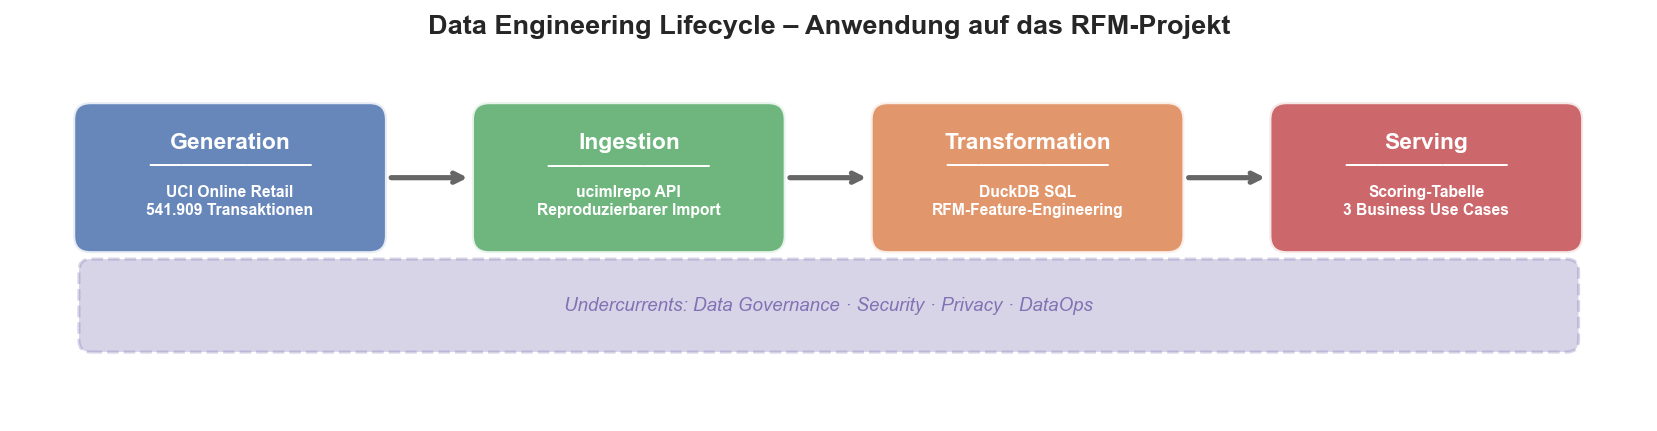

In [2]:
# Vorlesungsbezug 1: Data Engineering Lifecycle

fig, ax = plt.subplots(figsize=(14, 4.2))
ax.set_xlim(0, 14)
ax.set_ylim(0, 3.2)
ax.axis('off')
ax.set_aspect('equal')

# Lifecycle-Stufen, gemappt auf das RFM-Projekt
stages = [
    {'label': 'Generation\n──────────\nUCI Online Retail\n541.909 Transaktionen', 'x': 0.65, 'color': COLORS['primary']},
    {'label': 'Ingestion\n──────────\nucimlrepo API\nReproduzierbarer Import', 'x': 4.08, 'color': COLORS['success']},
    {'label': 'Transformation\n──────────\nDuckDB SQL\nRFM-Feature-Engineering', 'x': 7.51, 'color': COLORS['secondary']},
    {'label': 'Serving\n──────────\nScoring-Tabelle\n3 Business Use Cases', 'x': 10.94, 'color': COLORS['warning']},
]

for stage in stages:
    rect = mpatches.FancyBboxPatch((stage['x'], 1.55), 2.4, 1.0, boxstyle="round,pad=0.15",facecolor=stage['color'], alpha=0.85, edgecolor='white', linewidth=2)
    ax.add_patch(rect)
    # Titel + Trennlinie
    parts = stage['label'].split('\n')
    title_line = parts[0] + '\n' + parts[1]
    # Detail-Zeilen
    details = '\n'.join(parts[2:])
    ax.text(stage['x'] + 1.2, 2.25, title_line, ha='center', va='center', fontsize=11, color='white', fontweight='bold')
    ax.text(stage['x'] + 1.2, 1.85, details, ha='center', va='center', fontsize=7.5, color='white', fontweight='bold')

# Pfeile zwischen den Stufen
for i in range(3):
    ax.annotate('', xy=(stages[i+1]['x'] - 0.15, 2.05), xytext=(stages[i]['x'] + 2.55, 2.05), arrowprops=dict(arrowstyle='->', color='#666', lw=2.5))

# Undercurrent: Governance-Leiste
gov_rect = mpatches.FancyBboxPatch((0.65, 0.65), 12.7, 0.6, boxstyle="round,pad=0.1", facecolor=COLORS['accent'], alpha=0.3,
    edgecolor=COLORS['accent'], linewidth=1.5, linestyle='--')
ax.add_patch(gov_rect)
ax.text(7.0, 0.95, 'Undercurrents: Data Governance · Security · Privacy · DataOps', ha='center', va='center', fontsize=9, color=COLORS['accent'], fontstyle='italic')

ax.set_title('Data Engineering Lifecycle – Anwendung auf das RFM-Projekt', pad=5)
plt.subplots_adjust(top=0.88)
plt.show()

---
## 3. Methodik

### 3.1 Use Cases und Minimal-Sets

Für die weitere Untersuchung des Wert-Aufwand-Paradoxons wird für jeden Use Case das jeweilige MVDP definiert. Betrachtet werden drei Use Cases, die im Online-Retail klar messbaren Business-Mehrwert erzeugen.

1. Identifikation von High-Value-Kunden: Dafür wird das Minimal-Set genutzt, bestehend aus CustomerID, InvoiceDate, Quantity und UnitPrice, woraus die drei RFM-Kennzahlen abgeleitet werden. Das Scoring erfolgt über eine Quintil-basierte Einteilung (NTILE(5)) für jede Dimension, kombiniert zu einem gewichteten Gesamtscore. Der messbare Mehrwert besteht in der Identifikation der umsatzstärksten Kundensegmente, die typischerweise dem Pareto-Prinzip folgend einen überproportionalen Anteil am Gesamtumsatz ausmachen.

2. Churn-Erkennung: Reduziert das Minimal-Set auf CustomerID und InvoiceDate. Daraus werden die Kauffrequenz und die Tage seit dem letzten Kauf berechnet. Als Churn-Flag wird eine regelbasierte Schwelle definiert, die sich aus dem dreifachen medianen Kaufabstand im Datensatz ableitet. Dieser Ansatz wird bewusst regelbasiert statt ML-basiert gewählt, da er für Business-Stakeholder unmittelbar nachvollziehbar ist und bereits eine klare Handlungsanweisung liefert. Dieser Business-Mehrwert ist nach Reichheld und Sasser [9] erheblich, da die Neukundenakquise fünf- bis siebenmal teurer ist als die Bindung bestehender Kunden.

3. Cross-Selling durch Warenkorbanalyse: Nutzt InvoiceNo und StockCode als Minimal-Set, um Produktpaare zu identifizieren, die häufig gemeinsam gekauft werden. Über die Berechnung von Support, Confidence und Lift lassen sich Empfehlungen ableiten, die den durchschnittlichen Warenkorbwert erhöhen können.

### 3.2 Zentrale Designentscheidungen

Die Wahl von **DuckDB** [6] anstelle einer reinen Pandas-Lösung ist bewusst getroffen. DuckDB ermöglicht SQL-native Analyse auf einer spaltenorientierten Engine und stellt einen direkten Bezug zu den Vorlesungsinhalten über analytische Datenbanksysteme her [3]. Der Datenzugang über das offizielle **ucimlrepo-Paket** gewährleistet Reproduzierbarkeit ohne manuelle Datei-Uploads.

Bei der Datenbereinigung werden fehlende CustomerIDs bewusst entfernt statt imputiert. Dieser Trade-off nimmt 27 Prozent Datenverlust in Kauf, vermeidet aber das Risiko künstlicher Muster durch Imputation. Die verbleibenden rund 400.000 Zeilen von circa 4.300 Kunden bieten eine hinreichend große Stichprobe.

Die RFM-Gewichtung mit Monetary (0,40) > Frequency (0,35) > Recency (0,25) folgt der in der Direktmarketing-Literatur etablierten Priorisierung [8]. Eine Gleichgewichtung wurde getestet und ändert die Segmentzuordnung bei lediglich rund zehn Prozent der Kunden.

---
## 4. Implementierung

### 4.1 Datenimport

Der UCI Online Retail Datensatz wird über das offizielle Python-Paket ucimlrepo geladen. Dieses Vorgehen gewährleistet Reproduzierbarkeit ohne manuelle Datei-Uploads und ermöglicht eine vollständig automatisierte Ausführung des Notebooks.

In [3]:
# Datenimport: UCI Online Retail Dataset

# Datensatz über das offizielle UCI-Repository laden
online_retail = fetch_ucirepo(id=352)
df_raw = online_retail.data.original.copy()

print(f"Rohdaten geladen: {len(df_raw):,} Zeilen, {df_raw.shape[1]} Spalten\n")

# Spaltenübersicht mit Datentypen und fehlenden Werten
col_info = pd.DataFrame({
    'Datentyp': df_raw.dtypes,
    'Fehlend': df_raw.isnull().sum(),
    'Fehlend (%)': (df_raw.isnull().sum() / len(df_raw) * 100).round(1)
})
col_info

Rohdaten geladen: 541,909 Zeilen, 8 Spalten



,Datentyp,Fehlend,Fehlend (%)
InvoiceNo,str,0,0.0
StockCode,str,0,0.0
Description,str,1454,0.3
Quantity,int64,0,0.0
InvoiceDate,str,0,0.0
UnitPrice,float64,0,0.0
CustomerID,float64,135080,24.9
Country,str,0,0.0


### 4.2 Datenbereinigung

Die Bereinigung entfernt fehlende CustomerIDs, Stornierungen und ungültige Mengen oder Preise. Der resultierende Datenverlust verdeutlicht den in [Abschnitt 2.2](#sec22) beschriebenen Aufwand realer Transaktionsdaten.

In [4]:
# Datenbereinigung: Stornierungen und Nullwerte entfernen

con = duckdb.connect()

# Rohdaten in DuckDB registrieren
con.register('df_raw', df_raw)

# Bereinigung: Stornierungen, NULL-CustomerIDs, ungültige Werte entfernen
con.execute("""
    CREATE TABLE retail_clean AS
    SELECT
        CAST(InvoiceNo AS VARCHAR) AS InvoiceNo,
        CAST(StockCode AS VARCHAR) AS StockCode,
        Description,
        CAST(Quantity AS INTEGER) AS Quantity,
        InvoiceDate,
        CAST(UnitPrice AS DOUBLE) AS UnitPrice,
        CAST(CustomerID AS INTEGER) AS CustomerID,
        Country,
        CAST(Quantity AS DOUBLE) * CAST(UnitPrice AS DOUBLE) AS Revenue
    FROM df_raw
    WHERE CustomerID IS NOT NULL
      AND CAST(InvoiceNo AS VARCHAR) NOT LIKE 'C%'
      AND Quantity > 0
      AND UnitPrice > 0
""")

# Bereinigungsstatistik
stats = con.execute("""
    SELECT
        (SELECT COUNT(*) FROM df_raw) AS zeilen_roh,
        (SELECT COUNT(*) FROM retail_clean) AS zeilen_clean,
        (SELECT COUNT(DISTINCT CAST(CustomerID AS INTEGER))
         FROM df_raw WHERE CustomerID IS NOT NULL) AS kunden_roh,
        (SELECT COUNT(DISTINCT CustomerID) FROM retail_clean) AS kunden_clean
""").fetchdf()

removed = stats['zeilen_roh'].iloc[0] - stats['zeilen_clean'].iloc[0]
share = (1 - stats['zeilen_clean'].iloc[0] / stats['zeilen_roh'].iloc[0]) * 100

clean_stats = pd.DataFrame({
    'Zeilen': [f"{stats['zeilen_roh'].iloc[0]:,}", f"{stats['zeilen_clean'].iloc[0]:,}", f"{removed:,} ({share:.1f}%)"],
    'Kunden': [f"{stats['kunden_roh'].iloc[0]:,}", f"{stats['kunden_clean'].iloc[0]:,}", '']
}, index=['Rohdaten', 'Bereinigt', 'Entfernt'])
clean_stats

,Zeilen,Kunden
Rohdaten,"541,909","4,372"
Bereinigt,"397,884","4,338"
Entfernt,"144,025 (26.6%)",


### 4.3 RFM-Feature-Engineering

Aus den bereinigten Transaktionsdaten werden die drei RFM-Features Recency, Frequency und Monetary abgeleitet. Als Referenzdatum für die Recency-Berechnung wird der Tag nach der letzten Transaktion im Datensatz gewählt, um konsistente und vergleichbare Werte zu gewährleisten.

In [5]:
# RFM-Berechnung: Recency, Frequency und Monetary

# Referenzdatum: Tag nach der letzten Transaktion im Datensatz
df_rfm = con.execute("""
    WITH ref_date AS (
        SELECT DATE '2011-12-10' AS reference_date
    )
    SELECT
        CustomerID,
        DATEDIFF('day', MAX(STRPTIME(InvoiceDate, '%m/%d/%Y %H:%M')::DATE), (SELECT reference_date FROM ref_date)) AS Recency,
        COUNT(DISTINCT InvoiceNo) AS Frequency,
        ROUND(SUM(Revenue), 2) AS Monetary
    FROM retail_clean
    GROUP BY CustomerID
    HAVING SUM(Revenue) > 0
""").fetchdf()

print(f"RFM-Tabelle: {len(df_rfm):,} Kunden\n")

# Deskriptive Statistik der drei RFM-Dimensionen
df_rfm[['Recency', 'Frequency', 'Monetary']].describe().round(2)

RFM-Tabelle: 4,338 Kunden



,Recency,Frequency,Monetary
count,4338.00,4338.00,4338.00
mean,93.06,4.27,2054.27
std,100.01,7.70,8989.23
min,1.00,1.00,3.75
25%,18.00,1.00,307.41
50%,51.00,2.00,674.48
75%,142.75,5.00,1661.74
max,374.00,209.00,280206.02


<a id="sec44"></a>

### 4.4 Scoring und Kundensegmentierung

Das Scoring erfolgt über Quintile, wobei jede RFM-Dimension in fünf gleichgroße Gruppen aufgeteilt wird (1 = schlechteste, 5 = beste). Bei Recency wird die Logik invertiert, da ein niedriger Wert (kürzlich gekauft) positiv ist. Der gewichtete Gesamtscore reflektiert die Business-Priorisierung mit Monetary als stärkstem Einfluss, da der Umsatzbeitrag im Retail der direkteste Wertindikator ist.

In [6]:
# RFM-Scoring: Quintil-basierte Bewertung und Segmentierung

con.register('df_rfm', df_rfm)

df_scored = con.execute("""
    SELECT
        *,
        -- Quintile (1-5), Recency invertiert (niedrig = gut = hoher Score)
        NTILE(5) OVER (ORDER BY Recency DESC) AS R_Score,
        NTILE(5) OVER (ORDER BY Frequency ASC) AS F_Score,
        NTILE(5) OVER (ORDER BY Monetary ASC) AS M_Score
    FROM df_rfm
""").fetchdf()

# Gewichteter Gesamtscore
df_scored['RFM_Score'] = (
    df_scored['R_Score'] * 0.25 +
    df_scored['F_Score'] * 0.35 +
    df_scored['M_Score'] * 0.40
)

# Segmentierung
def assign_segment(score):
    if score >= 4.0:
        return 'Champions'
    elif score >= 3.0:
        return 'Loyal'
    elif score >= 2.5:
        return 'Promising'
    elif score >= 1.8:
        return 'At Risk'
    else:
        return 'Lost'

df_scored['Segment'] = df_scored['RFM_Score'].apply(assign_segment)

# Segmentübersicht
segment_summary = df_scored.groupby('Segment').agg(
    Customer_Count=('CustomerID', 'count'),
    Avg_Recency=('Recency', 'mean'),
    Avg_Frequency=('Frequency', 'mean'),
    Avg_Monetary=('Monetary', 'mean'),
    Total_Revenue=('Monetary', 'sum')
).round(1)

segment_order = ['Champions', 'Loyal', 'Promising', 'At Risk', 'Lost']
segment_summary = segment_summary.reindex(segment_order)
segment_summary['Revenue_Share_%'] = (segment_summary['Total_Revenue'] / segment_summary['Total_Revenue'].sum() * 100).round(1)

segment_summary

,Customer_Count,Avg_Recency,Avg_Frequency,Avg_Monetary,Total_Revenue,Revenue_Share_%
Segment,,,,,,
Champions,1187,21.5,10.3,5591.0,6636569.6,74.5
Loyal,963,52.4,3.3,1392.2,1340686.9,15.0
Promising,522,88.3,2.0,802.2,418754.6,4.7
At Risk,814,107.5,1.4,408.7,332651.7,3.7
Lost,852,227.9,1.1,214.5,182745.2,2.1


Die resultierende Scoring-Tabelle lässt sich als Datenprodukt im Sinne von Dehghanis DaaP-Konzept [5] bewerten. Sie ist über das dokumentierte Notebook auffindbar, über die CustomerID als Primärschlüssel adressierbar, durch versionierten und reproduzierbaren Code vertrauenswürdig und durch explizite Feature-Definitionen (Recency, Frequency, Monetary) selbstbeschreibend. Zudem ist sie durch das standardisierte Tabellenformat (DataFrame/CSV) interoperabel und durch die Aggregation auf Kundenebene sicher, da einzelne Transaktionen und persönliche Kaufdetails im Scoring nicht mehr enthalten sind. Damit erfüllt das RFM-Scoring alle sechs Kriterien eines Datenprodukts bei minimalem Datenumfang.

### 4.5 Churn-Flag-Ableitung

Die Churn-Schwelle wird empirisch aus dem Kaufverhalten abgeleitet. Für jeden Kunden mit mindestens zwei Käufen wird der durchschnittliche Kaufabstand berechnet und der Median über alle Kunden mit dem Faktor drei multipliziert. Wer drei erwartete Kaufzyklen verstreichen lässt, gilt als abgewandert. Dieser Ansatz ist auf andere Datensätze übertragbar.

In [7]:
# Churn-Flag: Empirisch abgeleitete Schwelle

# Mediane Kauffrequenz (Tage zwischen Käufen) berechnen
df_frequency = con.execute("""
    SELECT CustomerID,
           DATEDIFF('day', MIN(STRPTIME(InvoiceDate, '%m/%d/%Y %H:%M')::DATE),
                          MAX(STRPTIME(InvoiceDate, '%m/%d/%Y %H:%M')::DATE)) AS Span_Days,
           COUNT(DISTINCT InvoiceNo) AS Num_Orders
    FROM retail_clean
    GROUP BY CustomerID
    HAVING COUNT(DISTINCT InvoiceNo) >= 2
""").fetchdf()

df_frequency['Avg_Days_Between'] = df_frequency['Span_Days'] / (df_frequency['Num_Orders'] - 1)
median_gap = df_frequency['Avg_Days_Between'].median()

# Schwelle = 3x medianer Kaufabstand (Konvention: 3 ausgelassene Zyklen)
CHURN_THRESHOLD = int(round(median_gap * 3))
print(f"Medianer Kaufabstand:   {median_gap:.1f} Tage")
print(f"Churn-Schwelle (3x):    {CHURN_THRESHOLD} Tage")

# Flag setzen
df_scored['Churn'] = (df_scored['Recency'] >= CHURN_THRESHOLD).astype(int)

# Churn-Rate pro Segment
churn_by_segment = df_scored.groupby('Segment').agg(Customers=('CustomerID', 'count'), Churned=('Churn', 'sum')).reindex(segment_order)
churn_by_segment['Churn_Rate_%'] = (churn_by_segment['Churned'] / churn_by_segment['Customers'] * 100).round(1)

print(f"Gesamte Churn-Rate: {df_scored['Churn'].mean()*100:.1f}%\n")

churn_by_segment

Medianer Kaufabstand:   53.5 Tage
Churn-Schwelle (3x):    160 Tage
Gesamte Churn-Rate: 22.7%



,Customers,Churned,Churn_Rate_%
Segment,,,
Champions,1187,8,0.7
Loyal,963,38,3.9
Promising,522,111,21.3
At Risk,814,192,23.6
Lost,852,636,74.6


### 4.6 Cross-Selling durch eine Warenkorbanalyse

Das MVDP-Prinzip wird hier an einem zweiten Use Case demonstriert. Über einen Self-Join auf Invoice-Ebene werden Produktpaare identifiziert, die häufig gemeinsam gekauft werden. Support, Confidence und Lift quantifizieren die Assoziationsstärke mit nur zwei Rohdatenspalten (InvoiceNo, StockCode).

In [8]:
# Cross-Selling: Produktpaar-Analyse mit DuckDB

# Produktpaare pro Invoice (Self-Join)
# SQL: Self-Join auf Invoice-Ebene, Support/Confidence/Lift berechnen
df_cross = con.execute("""
    WITH product_invoices AS (
        SELECT DISTINCT InvoiceNo, StockCode, Description
        FROM retail_clean
        -- Nicht-Produkt-Codes ausschließen (Porto, Rabatte, Gebühren etc.)
        WHERE StockCode NOT IN ('POST', 'DOT', 'M', 'BANK CHARGES',
                                'PADS', 'CRUK', 'C2')
    ),
    total_invoices AS (
        SELECT COUNT(DISTINCT InvoiceNo) AS total FROM retail_clean
    ),
    pairs AS (
        SELECT
            a.StockCode AS Product_A,
            a.Description AS Desc_A,
            b.StockCode AS Product_B,
            b.Description AS Desc_B,
            COUNT(DISTINCT a.InvoiceNo) AS pair_count
        FROM product_invoices a
        JOIN product_invoices b
            ON a.InvoiceNo = b.InvoiceNo
            AND a.StockCode < b.StockCode
        GROUP BY a.StockCode, a.Description, b.StockCode, b.Description
        HAVING COUNT(DISTINCT a.InvoiceNo) >= 20
    ),
    single_counts AS (
        SELECT StockCode, COUNT(DISTINCT InvoiceNo) AS single_count
        FROM product_invoices
        GROUP BY StockCode
    )
    SELECT
        p.Desc_A,
        p.Desc_B,
        p.pair_count,
        ROUND(p.pair_count * 100.0 / t.total, 3) AS support_pct,
        ROUND(p.pair_count * 100.0 / sa.single_count, 1) AS confidence_A_pct,
        ROUND((p.pair_count * 1.0 / sa.single_count) /
              (sb.single_count * 1.0 / t.total), 2) AS lift
    FROM pairs p
    CROSS JOIN total_invoices t
    JOIN single_counts sa ON p.Product_A = sa.StockCode
    JOIN single_counts sb ON p.Product_B = sb.StockCode
    ORDER BY p.pair_count DESC
    LIMIT 10
""").fetchdf()

# Top-10 Produktpaare als formatierte Tabelle
df_cross_display = df_cross.rename(columns={
    'Desc_A': 'Produkt A',
    'Desc_B': 'Produkt B',
    'pair_count': 'Gemeinsam',
    'support_pct': 'Support (%)',
    'confidence_A_pct': 'Confidence (%)',
    'lift': 'Lift'
})
df_cross_display.index = range(1, len(df_cross_display) + 1)
df_cross_display

,Produkt A,Produkt B,Gemeinsam,Support (%),Confidence (%),Lift
1,JUMBO BAG PINK POLKADOT,JUMBO BAG RED RETROSPOT,546,2.946,62.7,7.26
2,GREEN REGENCY TEACUP AND SAUCER,ROSES REGENCY TEACUP AND SAUCER,541,2.919,78.3,18.53
3,ALARM CLOCK BAKELIKE GREEN,ALARM CLOCK BAKELIKE RED,530,2.860,67.2,14.19
4,LUNCH BAG RED RETROSPOT,LUNCH BAG PINK POLKADOT,523,2.822,40.6,8.08
5,LUNCH BAG RED RETROSPOT,LUNCH BAG BLACK SKULL.,517,2.790,40.1,7.07
6,WOODEN PICTURE FRAME WHITE FINISH,WOODEN FRAME ANTIQUE WHITE,468,2.525,53.4,12.21
7,LUNCH BAG RED RETROSPOT,LUNCH BAG SPACEBOY DESIGN,467,2.520,36.2,6.80
8,LUNCH BAG BLACK SKULL.,LUNCH BAG PINK POLKADOT,464,2.504,44.1,8.78
9,GARDENERS KNEELING PAD CUP OF TEA,GARDENERS KNEELING PAD KEEP CALM,463,2.498,72.9,17.87
10,GREEN REGENCY TEACUP AND SAUCER,PINK REGENCY TEACUP AND SAUCER,460,2.482,66.6,22.19


<a id="sec47"></a>

### 4.7 Kernexperiment zum Wert-Aufwand-Paradoxon

Dieses Experiment adressiert die Wert-Seite der These, denn wenn zusätzliche Features das Kunden-Ranking kaum verändern, liefern sie keinen substanziellen Informationsgewinn. Die Aufwand-Seite mit Governance-Overhead, DSGVO-Komplexität und Wartungskosten wird in [Abschnitt 6](#sec6) qualitativ diskutiert. Als Testmaß dient die Spearman-Rangkorrelation, wobei ein Wert nahe 1,0 bedeutet, dass die Rangfolge praktisch unverändert bleibt.

In [9]:
# Kernexperiment: Feature-Erweiterungen vs. Baseline

# Zusätzliche Features aus dem Datensatz ableiten
df_extra = con.execute("""
    SELECT
        CustomerID,
        COUNT(DISTINCT Country) AS Num_Countries,
        ROUND(AVG(Revenue), 2) AS Avg_Basket_Value,
        COUNT(DISTINCT StockCode) AS Num_Distinct_Products,
        -- Wochentag-Entropie (wie breit streuen die Kauftage?)
        COUNT(DISTINCT DAYOFWEEK(STRPTIME(InvoiceDate, '%m/%d/%Y %H:%M')::DATE)) AS Num_Distinct_Weekdays
    FROM retail_clean
    GROUP BY CustomerID
""").fetchdf()

# Merge mit RFM-Scores
df_experiment = df_scored.merge(df_extra, on='CustomerID', how='inner')

# Baseline-Ranking (nur RFM)
df_experiment['Rank_Baseline'] = df_experiment['RFM_Score'].rank(ascending=False)

# Min-Max-Normalisierung auf [0, 1]
def normalize(series):
    return (series - series.min()) / (series.max() - series.min() + 1e-10)

extensions = {
    '+ Country': 'Num_Countries',
    '+ Avg Basket': 'Avg_Basket_Value',
    '+ Wochentag': 'Num_Distinct_Weekdays',
    '+ Produktanzahl': 'Num_Distinct_Products'
}

WEIGHT_EXTRA = 0.15  # 15% Gewicht für das Zusatzfeature

results = {}
for label, col in extensions.items():
    extra_norm = normalize(df_experiment[col])
    extended_score = df_experiment['RFM_Score'] * (1 - WEIGHT_EXTRA) + extra_norm * 5 * WEIGHT_EXTRA
    rank_extended = extended_score.rank(ascending=False)

    corr, pvalue = spearmanr(df_experiment['Rank_Baseline'], rank_extended)
    results[label] = {
        'Spearman_rho': round(corr, 4),
        'Ranking_Change_%': round((1 - abs(corr)) * 100, 2),
        'p_value': pvalue
    }

df_results = pd.DataFrame(results).T
print(f"Baseline: RFM-Score (R*0.25 + F*0.35 + M*0.40)")
print(f"Erweiterung: Zusatzfeature mit {WEIGHT_EXTRA*100:.0f}% Gewicht\n")

df_results

Baseline: RFM-Score (R*0.25 + F*0.35 + M*0.40)
Erweiterung: Zusatzfeature mit 15% Gewicht



,Spearman_rho,Ranking_Change_%,p_value
+ Country,0.9997,0.03,0.0
+ Avg Basket,0.9992,0.08,0.0
+ Wochentag,0.9961,0.39,0.0
+ Produktanzahl,0.9992,0.08,0.0


---
## 5. Ergebnisse und Visualisierungen

Die folgenden Visualisierungen belegen die zentralen Erkenntnisse. Die Pareto-Kurve veranschaulicht die Umsatzkonzentration, die Segmentanalyse zeigt die Churn-Korrelation und das Ranking-Experiment quantifiziert den marginalen Wert zusätzlicher Datenpunkte. Abschließend ordnet die Aufwand-Wert-Matrix die Ergebnisse in den Gesamtkontext ein.

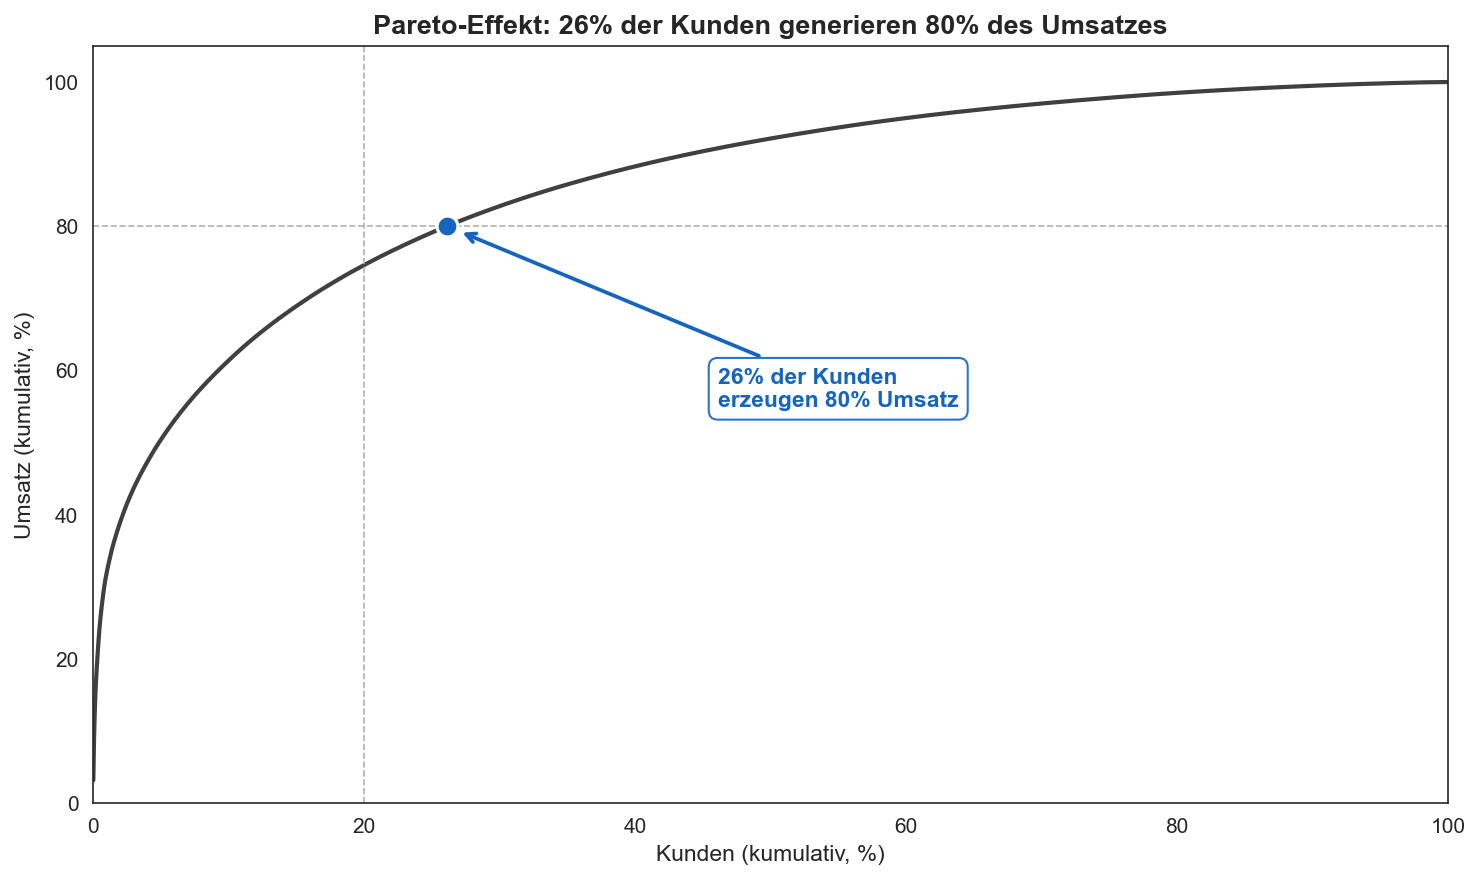

In [10]:
# Visualisierung 1: Pareto-Kurve (IBCS-konform)

# Kunden nach Umsatz absteigend sortieren und kumulativen Anteil berechnen
df_pareto = df_scored.sort_values('Monetary', ascending=False).reset_index(drop=True)
df_pareto['Cumulative_Revenue'] = df_pareto['Monetary'].cumsum()
df_pareto['Cumulative_Revenue_%'] = df_pareto['Cumulative_Revenue'] / df_pareto['Monetary'].sum() * 100
df_pareto['Customers_%'] = (df_pareto.index + 1) / len(df_pareto) * 100

fig, ax = plt.subplots(figsize=(10, 6))

# Kumulative Umsatzkurve
ax.plot(df_pareto['Customers_%'], df_pareto['Cumulative_Revenue_%'], color=IBCS['actual'], linewidth=2)

# Referenzlinien bei 80% Umsatz und 20% Kunden (klassisches Pareto-Prinzip)
ax.axhline(y=80, color=IBCS['plan'], linestyle='--', linewidth=0.8)
ax.axvline(x=20, color=IBCS['plan'], linestyle='--', linewidth=0.8)

# Tatsächlichen Schnittpunkt bei 80% Umsatz markieren
idx_80 = (df_pareto['Cumulative_Revenue_%'] >= 80).idxmax()
pct_customers_80 = df_pareto.loc[idx_80, 'Customers_%']
ax.scatter([pct_customers_80], [80], color=IBCS['highlight'], s=100, zorder=5, edgecolors='white', linewidth=1.5)

# Annotation mit Pfeil zum Schnittpunkt
ax.annotate(f'{pct_customers_80:.0f}% der Kunden\nerzeugen 80% Umsatz', xy=(pct_customers_80, 80), xytext=(pct_customers_80 + 20, 55),
            fontsize=11, fontweight='bold', color=IBCS['highlight'],
            arrowprops=dict(arrowstyle='->', color=IBCS['highlight'], lw=1.8, shrinkB=8),
            bbox=dict(boxstyle='round,pad=0.4', facecolor='white', edgecolor=IBCS['highlight'], alpha=0.9))

ax.set_xlabel('Kunden (kumulativ, %)')
ax.set_ylabel('Umsatz (kumulativ, %)')
ax.set_title(f'Pareto-Effekt: {pct_customers_80:.0f}% der Kunden generieren 80% des Umsatzes')
ax.set_xlim(0, 100)
ax.set_ylim(0, 105)
plt.tight_layout()
plt.show()

Die Pareto-Kurve bestätigt die theoretische Erwartung: Ein kleiner Anteil der Kunden generiert den Großteil des Umsatzes. Bereits die Identifikation dieser Top-Kunden ermöglicht eine zielgerichtete Allokation von Marketing- und Retention-Budgets.

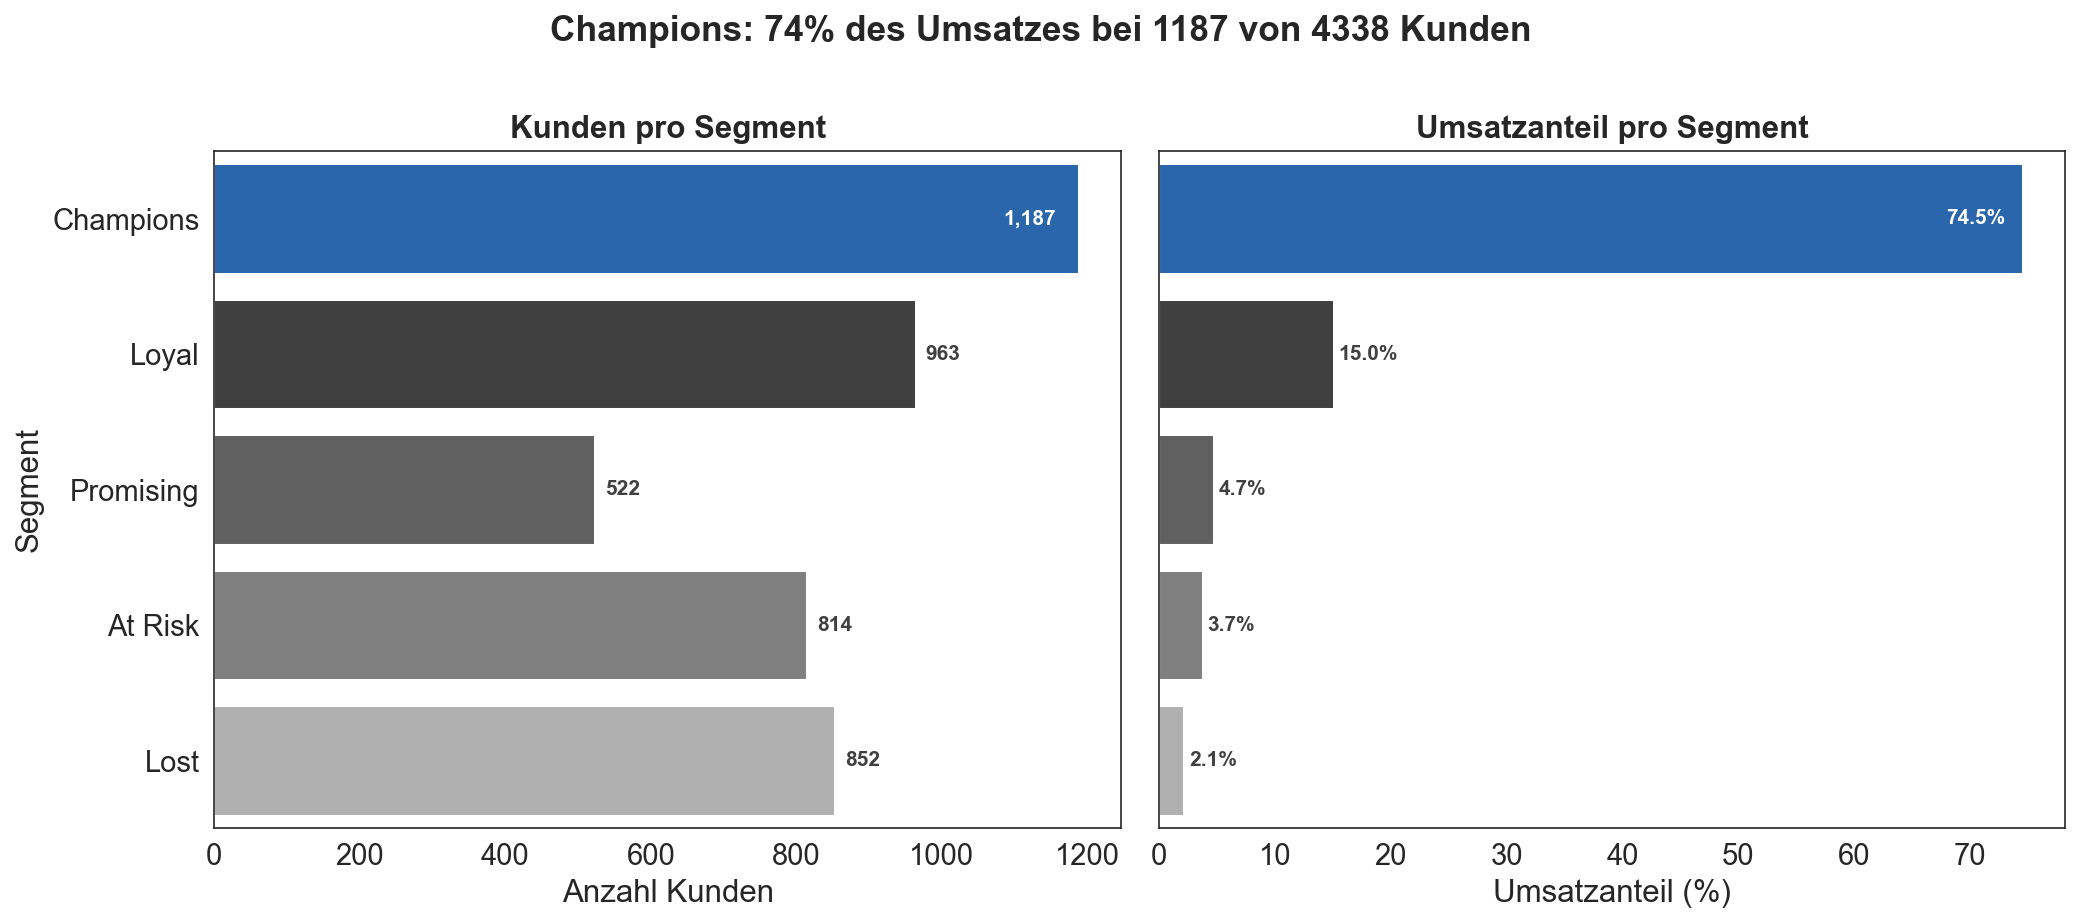

In [11]:
# Visualisierung 2: Segmentverteilung und Umsatzanteil (IBCS-konform)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
ax_fontsize = 14  # Skaliert für figsize=(14,6)

# Farben pro Segment (Champions hervorgehoben, Rest in Graustufen)
colors_list = [SEGMENT_COLORS[s] for s in segment_order if s in segment_summary.index]
seg_plot = segment_summary.reindex(segment_order).reset_index()

# Links: Kundenanzahl pro Segment
sns.barplot(data=seg_plot, y='Segment', x='Customer_Count', palette=colors_list, ax=axes[0], order=segment_order, edgecolor='white', linewidth=0.5)
axes[0].set_xlabel('Anzahl Kunden', fontsize=15)
axes[0].set_ylabel('Segment', fontsize=15)
axes[0].set_title('Kunden pro Segment', fontsize=15)
for i, v in enumerate(segment_summary.reindex(segment_order)['Customer_Count']):
    if segment_order[i] == 'Champions':
        axes[0].text(v - 30, i, f'{int(v):,}', va='center', ha='right', fontsize=10, fontweight='bold', color='white')
    else:
        axes[0].text(v + 15, i, f'{int(v):,}', va='center', fontsize=10, fontweight='bold', color=IBCS['annotation'])

# Rechts: Umsatzanteil pro Segment (Y-Labels entfernt, da links bereits vorhanden)
sns.barplot(data=seg_plot, y='Segment', x='Revenue_Share_%', palette=colors_list, ax=axes[1], order=segment_order, edgecolor='white', linewidth=0.5)
axes[1].set_xlabel('Umsatzanteil (%)', fontsize=15)
axes[1].set_ylabel('')
axes[1].set_yticklabels([])
axes[1].set_title('Umsatzanteil pro Segment', fontsize=15)
for i, v in enumerate(segment_summary.reindex(segment_order)['Revenue_Share_%']):
    if segment_order[i] == 'Champions':
        axes[1].text(v - 1.5, i, f'{v:.1f}%', va='center', ha='right', fontsize=10, fontweight='bold', color='white')
    else:
        axes[1].text(v + 0.5, i, f'{v:.1f}%', va='center', fontsize=10, fontweight='bold', color=IBCS['annotation'])

# Gesamttitel mit Champions-Kennzahl
champ_pct = segment_summary.loc['Champions', 'Revenue_Share_%']
champ_n = int(segment_summary.loc['Champions', 'Customer_Count'])
total_n = int(segment_summary['Customer_Count'].sum())
axes[0].tick_params(labelsize=14)
axes[1].tick_params(labelsize=14)

plt.suptitle(f'Champions: {champ_pct:.0f}% des Umsatzes bei {champ_n} von {total_n} Kunden', fontsize=17, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

Die Segmentverteilung zeigt eine deutliche Asymmetrie, denn Champions und Loyal-Kunden vereinen einen überproportionalen Umsatzanteil bei vergleichsweise geringer Kundenzahl. Die Segmente At Risk und Lost umfassen eine ähnliche Kundenzahl, tragen jedoch nur einen Bruchteil zum Gesamtumsatz bei. Dies bestätigt das Pareto-Prinzip auf Segment-Ebene.

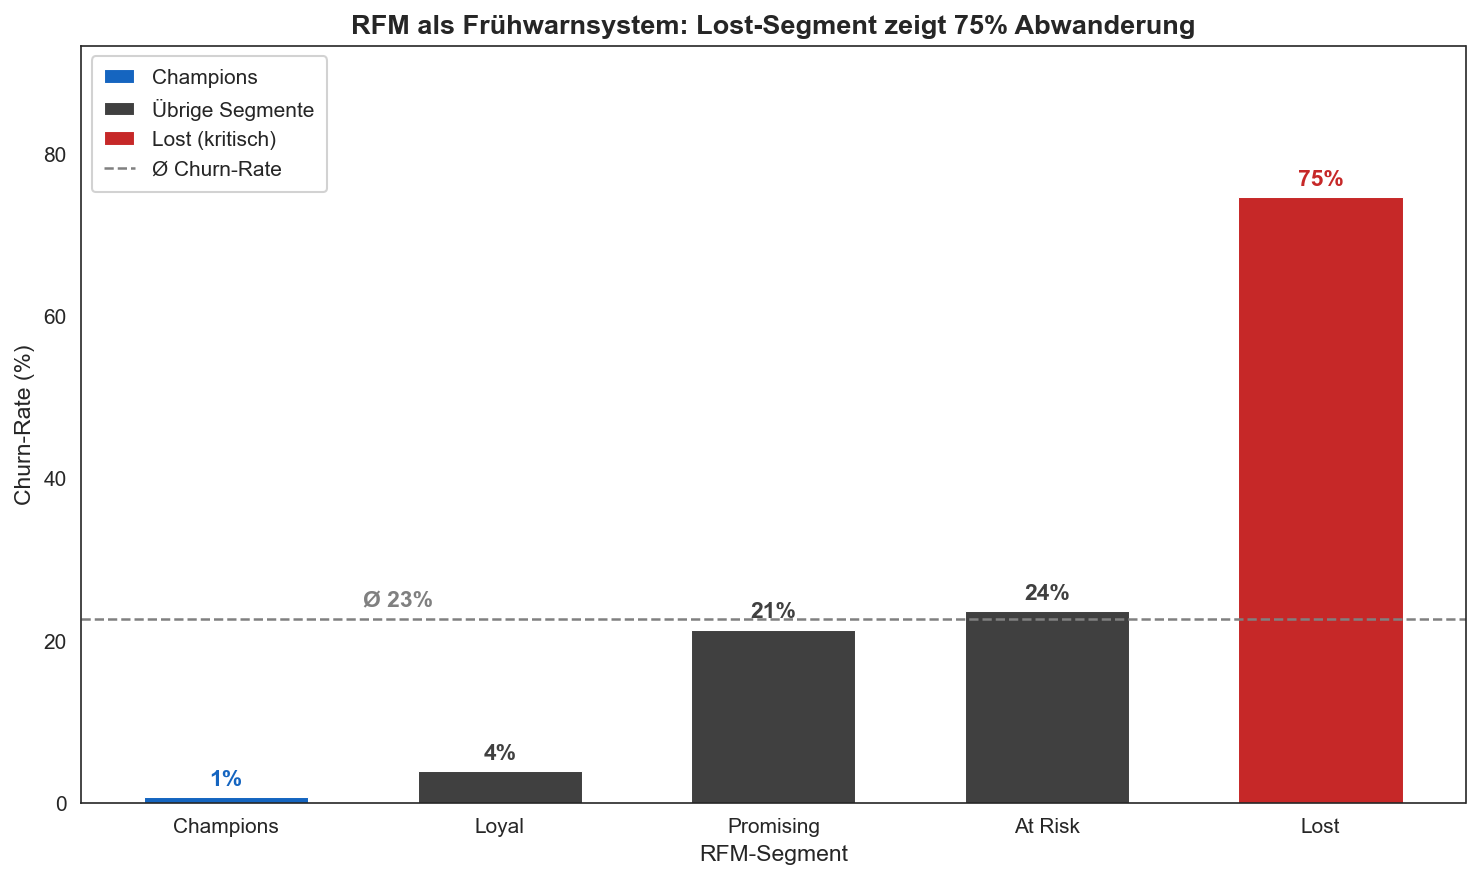

In [12]:
# Visualisierung 3: Churn-Rate nach RFM-Segment (IBCS-konform)

fig, ax = plt.subplots(figsize=(10, 6))

churn_plot = churn_by_segment.reindex(segment_order).reset_index()

# Farbzuweisung: Lost rot, Champions blau, Rest dunkelgrau
bar_colors = [IBCS['highlight_neg'] if s == 'Lost'
              else IBCS['highlight'] if s == 'Champions'
              else IBCS['actual'] for s in segment_order]

# Balkendiagramm mit Churn-Rate pro Segment
ax.bar(range(len(segment_order)), [churn_by_segment.loc[s, 'Churn_Rate_%'] for s in segment_order], color=bar_colors, edgecolor='white', linewidth=0.5, width=0.6)
ax.set_xticks(range(len(segment_order)))
ax.set_xticklabels(segment_order)
ax.set_xlabel('RFM-Segment')

# Prozentwerte über den Balken (farblich passend zum Segment)
for idx, segment in enumerate(segment_order):
    rate = churn_by_segment.loc[segment, 'Churn_Rate_%']
    label_color = (IBCS['highlight'] if segment == 'Champions'
                   else IBCS['highlight_neg'] if segment == 'Lost'
                   else IBCS['annotation'])
    ax.text(idx, rate + 1.5, f'{rate:.0f}%', ha='center', fontweight='bold', fontsize=11, color=label_color)

# Durchschnittliche Churn-Rate als Referenzlinie
avg_churn = df_scored['Churn'].mean() * 100
ax.axhline(y=avg_churn, color=IBCS['previous'], linestyle='--', linewidth=1.2)
ax.text(0.5, avg_churn + 1.5, f'Ø {avg_churn:.0f}%', ha='left', fontsize=11, fontweight='bold', color=IBCS['previous'])

# Legende
legend_handles = [
    Patch(facecolor=IBCS['highlight'], label='Champions'),
    Patch(facecolor=IBCS['actual'], label='Übrige Segmente'),
    Patch(facecolor=IBCS['highlight_neg'], label='Lost (kritisch)'),
    Line2D([0], [0], color=IBCS['previous'], linestyle='--', linewidth=1.2, label=f'Ø Churn-Rate'),
]
ax.legend(handles=legend_handles, loc='upper left', fontsize=10, frameon=True, facecolor='white', edgecolor='#D0D0D0', framealpha=0.95, borderpad=0.6, handlelength=1.5)

ax.set_ylabel('Churn-Rate (%)')
ax.set_title(f'RFM als Frühwarnsystem: Lost-Segment zeigt 'f'{churn_by_segment.loc["Lost", "Churn_Rate_%"]:.0f}% Abwanderung')
ax.set_ylim(0, churn_plot['Churn_Rate_%'].max() * 1.25)
plt.tight_layout()
plt.show()

Die Churn-Rate korreliert invers mit dem RFM-Score, denn Champions zeigen nur 1 Prozent Abwanderung gegenüber 75 Prozent im Lost-Segment. Das RFM-Scoring fungiert damit simultan als Wertindikator und Frühwarnsystem aus denselben drei Features. Die Warenkorbanalyse bestätigt das MVDP-Prinzip zusätzlich, denn bereits zwei Rohdatenspalten genügen für umsatzsteigernde Produktempfehlungen mit Lift-Werten über 22.

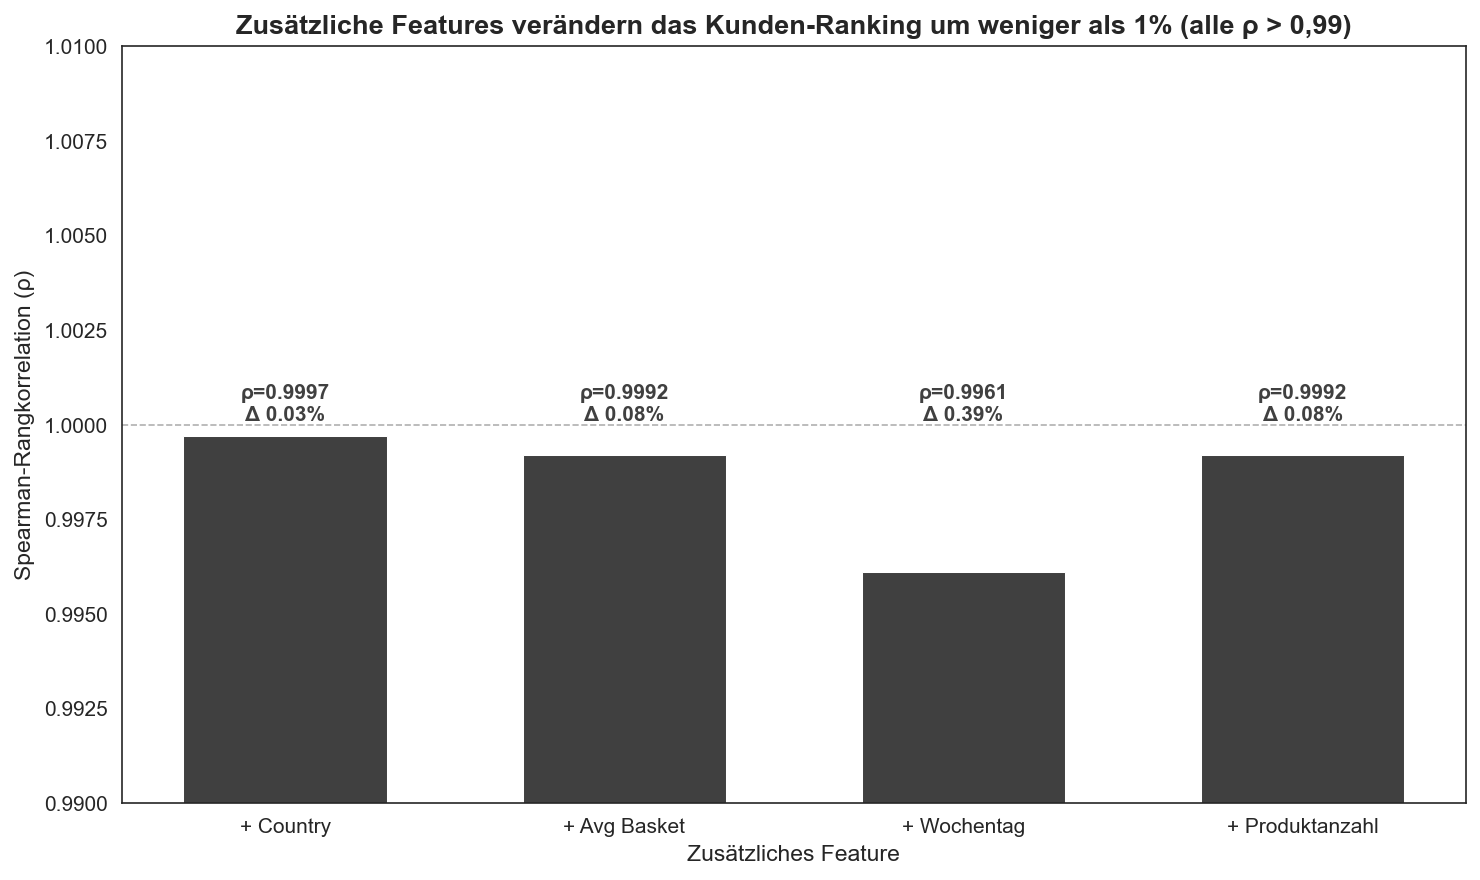

In [13]:
# Visualisierung 4: Ranking-Korrelation (IBCS-konform)

fig, ax = plt.subplots(figsize=(10, 6))

df_rank_plot = df_results.reset_index()
df_rank_plot.columns = ['Feature', 'Spearman_rho', 'Ranking_Change_%', 'p_value']

# Alle Balken dunkelgrau
ax.bar(range(len(df_rank_plot)), df_rank_plot['Spearman_rho'], color=IBCS['actual'], edgecolor='white', linewidth=0.5, width=0.6)
ax.set_xticks(range(len(df_rank_plot)))
ax.set_xticklabels(df_rank_plot['Feature'])
ax.set_xlabel('Zusätzliches Feature')

# Beschriftung auf einheitlicher Höhe (knapp über dem höchsten Balken)
label_y = df_rank_plot['Spearman_rho'].max() + 0.0004
for i, row in df_rank_plot.iterrows():
    ax.text(i, label_y,
            f'\u03c1={row["Spearman_rho"]:.4f}\n\u0394 {row["Ranking_Change_%"]:.2f}%',
            ha='center', fontsize=10, fontweight='bold', color=IBCS['annotation'])

# Referenzlinie bei 1.0 (perfekte Korrelation)
ax.axhline(y=1.0, color=IBCS['plan'], linestyle='--', linewidth=0.8)

ax.set_ylabel('Spearman-Rangkorrelation (\u03c1)')
ax.set_title('Zusätzliche Features verändern das Kunden-Ranking um weniger als 1% (alle \u03c1 > 0,99)')
ax.set_ylim(0.99, 1.01)
plt.tight_layout()
plt.show()

Das Ranking-Experiment quantifiziert den marginalen Informationsgewinn, denn alle Spearman-Korrelationen liegen über 0,99 bei einer maximalen Ranking-Veränderung von unter 0,4 Prozent. Die Hinzunahme von Herkunftsland, Warenkorbwert, Kauf-Wochentag oder Produktanzahl verändert das Kunden-Ranking also kaum. In Kombination mit dem in Abschnitt 6 diskutierten Governance-Aufwand zusätzlicher Daten ergibt sich ein klares Gesamtbild, denn der marginale Wert rechtfertigt den überproportionalen Aufwand nicht.

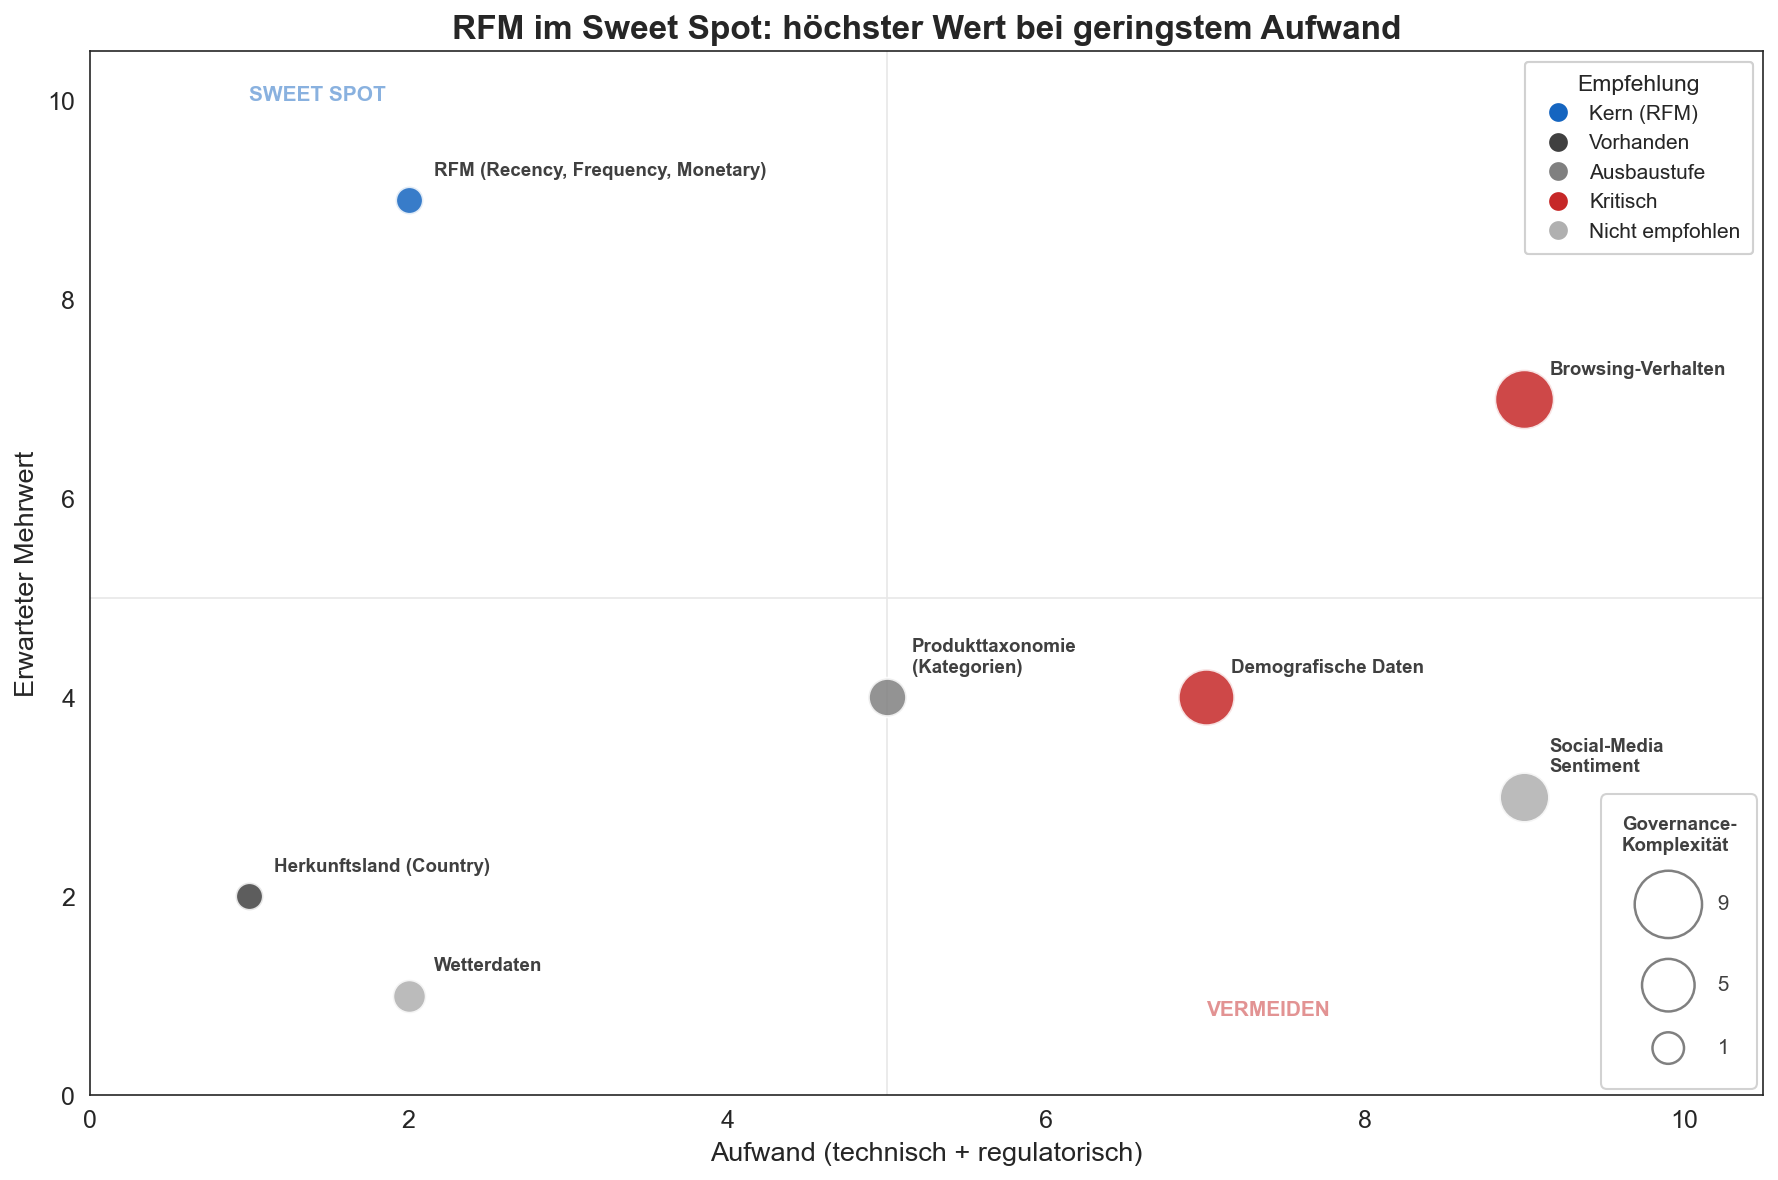

Datengestützte Wert-Ableitung



,Feature,Ranking-Δ (%),Wert-Score,Herleitung
1,Country,0.03,2,Spearman-Experiment
2,Produktanzahl,0.08,2,Spearman-Experiment
3,Taxonomie,Proxy (0.08),4,Proxy (2) + Empfehlungspotenzial (+2)


In [14]:
# Visualisierung 5: Aufwand-Wert-Matrix (IBCS-konform)

# Mapping-Funktion: Ranking-Veränderung aus dem Spearman-Experiment in Wert-Score übersetzen
def delta_to_value(delta_pct):
    if delta_pct < 0.1:  return 2
    elif delta_pct < 0.5: return 3
    elif delta_pct < 2.0: return 5
    elif delta_pct < 5.0: return 7
    else: return 9

# Datengestützte Wert-Scores aus dem Experiment ableiten
value_country = delta_to_value(df_results.loc['+ Country', 'Ranking_Change_%'])
value_product = delta_to_value(df_results.loc['+ Produktanzahl', 'Ranking_Change_%'])

# Herleitung der Wert-Scores als Tabelle
df_derivation = pd.DataFrame({
    'Feature': ['Country', 'Produktanzahl', 'Taxonomie'],
    'Ranking-Δ (%)': [
        f"{df_results.loc['+ Country', 'Ranking_Change_%']:.2f}",
        f"{df_results.loc['+ Produktanzahl', 'Ranking_Change_%']:.2f}",
        f"Proxy ({df_results.loc['+ Produktanzahl', 'Ranking_Change_%']:.2f})"
    ],
    'Wert-Score': [value_country, value_product, value_product + 2],
    'Herleitung': ['Spearman-Experiment', 'Spearman-Experiment', f'Proxy ({value_product}) + Empfehlungspotenzial (+2)']
})
df_derivation.index = range(1, len(df_derivation) + 1)

# Bewertungsmatrix: 7 Datenquellen mit Wert, Aufwand und Governance (jeweils 1-9)
features_assessment = pd.DataFrame({
    'Feature': ['RFM (Recency, Frequency, Monetary)', 'Herkunftsland (Country)', 'Produkttaxonomie\n(Kategorien)', 'Demografische Daten',
                'Social-Media\nSentiment', 'Browsing-Verhalten', 'Wetterdaten'],
    'Value': [9, value_country, value_product + 2, 4, 3, 7, 1],
    'Effort': [2, 1, 5, 7, 9, 9, 2],
    'Governance': [1, 1, 3, 8, 6, 9, 2],
    'Recommendation': ['Core', 'Available', 'Stage 2', 'Critical', 'Not recommended', 'Critical', 'Not recommended']
})

fig, ax = plt.subplots(figsize=(12, 8))

# Farben pro Empfehlungskategorie
ibcs_colors = {
    'Core': IBCS['highlight'],
    'Available': IBCS['actual'],
    'Stage 2': IBCS['previous'],
    'Critical': IBCS['highlight_neg'],
    'Not recommended': IBCS['plan'],
}

# Governance-Wert in Blasengröße umrechnen
def gov_to_s(g):
    return g * 80 + 100

# Bubble-Chart: Position = Aufwand/Wert, Größe = Governance, Farbe = Empfehlung
for _, row in features_assessment.iterrows():
    color = ibcs_colors.get(row['Recommendation'], IBCS['actual'])
    ax.scatter(row['Effort'], row['Value'], s=gov_to_s(row['Governance']), c=color, alpha=0.85, edgecolors='white', linewidth=1.5, zorder=3)
    ax.annotate(row['Feature'], xy=(row['Effort'], row['Value']), xytext=(12, 12), textcoords='offset points', fontsize=9, fontweight='bold', color=IBCS['annotation'])

# Quadranten-Trennlinien bei Score 5
ax.axhline(y=5, color=IBCS['gridline'], linestyle='-', linewidth=0.8, zorder=1)
ax.axvline(x=5, color=IBCS['gridline'], linestyle='-', linewidth=0.8, zorder=1)

# Quadranten-Labels
ax.text(1.0, 10, 'SWEET SPOT', fontsize=10, color=IBCS['highlight'], fontweight='bold', alpha=0.5)
ax.text(7.0, 0.8, 'VERMEIDEN', fontsize=10, color=IBCS['highlight_neg'], fontweight='bold', alpha=0.5)

ax.set_xlabel('Aufwand (technisch + regulatorisch)', fontsize=13)
ax.set_ylabel('Erwarteter Mehrwert', fontsize=13)
ax.set_title('RFM im Sweet Spot: höchster Wert bei geringstem Aufwand', fontsize=16)
ax.tick_params(labelsize=12)
ax.set_xlim(0, 10.5)
ax.set_ylim(0, 10.5)

# Legende: Empfehlungskategorien
legend_handles = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor=ibcs_colors['Core'],
           markersize=10, markeredgecolor='white', markeredgewidth=1, label='Kern (RFM)'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor=ibcs_colors['Available'],
           markersize=10, markeredgecolor='white', markeredgewidth=1, label='Vorhanden'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor=ibcs_colors['Stage 2'],
           markersize=10, markeredgecolor='white', markeredgewidth=1, label='Ausbaustufe'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor=ibcs_colors['Critical'],
           markersize=10, markeredgecolor='white', markeredgewidth=1, label='Kritisch'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor=ibcs_colors['Not recommended'],
           markersize=10, markeredgecolor='white', markeredgewidth=1, label='Nicht empfohlen'),
]
leg1 = ax.legend(handles=legend_handles, loc='upper right', fontsize=10, title='Empfehlung', title_fontsize=11, frameon=True, facecolor='white', edgecolor='#D0D0D0',
                 framealpha=0.95, borderpad=0.6, handletextpad=0.5)
ax.add_artist(leg1)

# Bubble-Größen-Legende für Governance-Komplexität
max_r = np.sqrt(gov_to_s(9) / np.pi)
da_w = max_r * 2 + 6

bubble_rows = []
for gov_val in [9, 5, 1]:
    r = np.sqrt(gov_to_s(gov_val) / np.pi)
    da = DrawingArea(da_w, r * 2 + 4, 0, 0)
    circle = MplCircle((da_w / 2, r + 2), r, facecolor='none', edgecolor=IBCS['previous'], linewidth=1.2)
    da.add_artist(circle)
    txt = TextArea(f' {gov_val}', textprops=dict(fontsize=10, color=IBCS['annotation']))
    row = HPacker(children=[da, txt], align='center', pad=0, sep=2)
    bubble_rows.append(row)

title_area = TextArea('Governance-\nKomplexität', textprops=dict(fontsize=9, fontweight='bold', color=IBCS['annotation']))
vbox = VPacker(children=[title_area] + bubble_rows, align='center', pad=2, sep=6)

anchored = AnchoredOffsetbox(loc='lower right', child=vbox, pad=0.5, frameon=True, borderpad=0.6)
anchored.patch.set_facecolor('white')
anchored.patch.set_edgecolor('#D0D0D0')
anchored.patch.set_alpha(0.95)
anchored.patch.set_boxstyle('round,pad=0.3')
ax.add_artist(anchored)

plt.tight_layout()
plt.show()

print("Datengestützte Wert-Ableitung\n")
df_derivation

Die Aufwand-Wert-Matrix bewertet sieben potenzielle Datenquellen auf drei Dimensionen mit Scores von jeweils 1 bis 9. Die Wert-Scores der im Datensatz vorhandenen Features sind datengestützt aus dem Spearman-Experiment abgeleitet, wobei Herkunftsland (Δ = 0,03 Prozent) und Produktanzahl (Δ = 0,08 Prozent) empirisch marginalen Zugewinn zeigen und entsprechend niedrige Wert-Scores erhalten. Für externe Quellen wie Demografie, Social Media, Browsing und Wetter basiert die Bewertung auf Fachliteratur. Aufwand und Governance sind qualitativ eingestuft, wobei die Blasengröße die Governance-Komplexität kodiert. RFM liegt klar im Sweet Spot mit höchstem Wert bei geringstem Aufwand und minimaler Governance.

<a id="sec6"></a>

---
## 6. Kritische Würdigung

Die zentrale Stärke des RFM-Ansatzes liegt in seiner Interpretierbarkeit und Effizienz. Das Scoring erfüllt alle sechs DaaP-Kriterien nach Dehghani [5] bei nur drei Features und hält den Governance-Overhead mit Ø 1,6 minimal gegenüber Faktor 4,5× bei erweitertem Datensatz (Visualisierung 6).

Dem stehen methodische Schwächen gegenüber. Das statische Scoring liefert Korrelationen, aber keine Kausalerklärungen, denn ein sinkender Score kann Abwanderung oder saisonale Muster widerspiegeln. Der Beobachtungszeitraum von zwölf Monaten verhindert die Trennung von Saisonalität und Trend. Ein Selektionsbias durch 25 Prozent fehlende CustomerIDs könnte die Segmentverteilung systematisch verzerren. Die Churn-Schwelle von 160 Tagen ist willkürlich im Multiplikator.

Die Risiken erstrecken sich über drei Ebenen. Operativ verfälschen fehlende oder duplizierte Rechnungen Frequency und Monetary direkt. Geschäftlich besteht Fehlallokationsrisiko bei fälschlich identifizierten Champions, etwa wenn einmalige B2B-Großbestellungen den Monetary-Score verzerren. Regulatorisch ist trotz aggregierter Scores eine Re-Identifikation nicht auszuschließen, was nach DSGVO Art. 35 eine Datenschutzfolgeabschätzung erfordert [2].

Bei den Einsatzgrenzen funktioniert das Modell im B2C-Transaktionsgeschäft mit wiederholten Käufen, nicht aber bei Subscriptions (Recency irrelevant), im B2B (zu kleine Stichprobe) oder bei Einmalkauf-Produkten. Die Ergebnisse beschränken sich auf einen britischen Händler ohne abgesicherte Generalisierbarkeit.

Als Alternativen bieten ML-Modelle wie Gradient Boosting höhere Prädiktionsgenauigkeit bei geringerer Interpretierbarkeit. BG/NBD-Modelle nach Fader und Hardie [7] liefern Kaufwahrscheinlichkeiten statt statischer Scores. Ein hybrider Ansatz mit RFM als Erstfilter und ML für kritische Segmente würde beides verbinden.

Kritisch zu den verwendeten Quellen ist anzumerken, dass Hughes' RFM [8] aus 1994 sich auf physisches Direktmarketing mit längeren Kaufzyklen als im E-Commerce bezieht. Dehghanis Data-Mesh [5] ist auf Großunternehmen zugeschnitten, weshalb diese Arbeit die DaaP-Kriterien ohne Mesh-Struktur adaptiert. Reichheld und Sassers These [9] zur fünf- bis siebenfach teureren Neukundenakquise basiert auf wenigen unkontrollierten Fallbeispielen. Reis und Housley [10] quantifizieren nicht den Wertbeitrag einzelner Lifecycle-Phasen, was das Spearman-Experiment (alle ρ > 0,99) teilweise ergänzt.

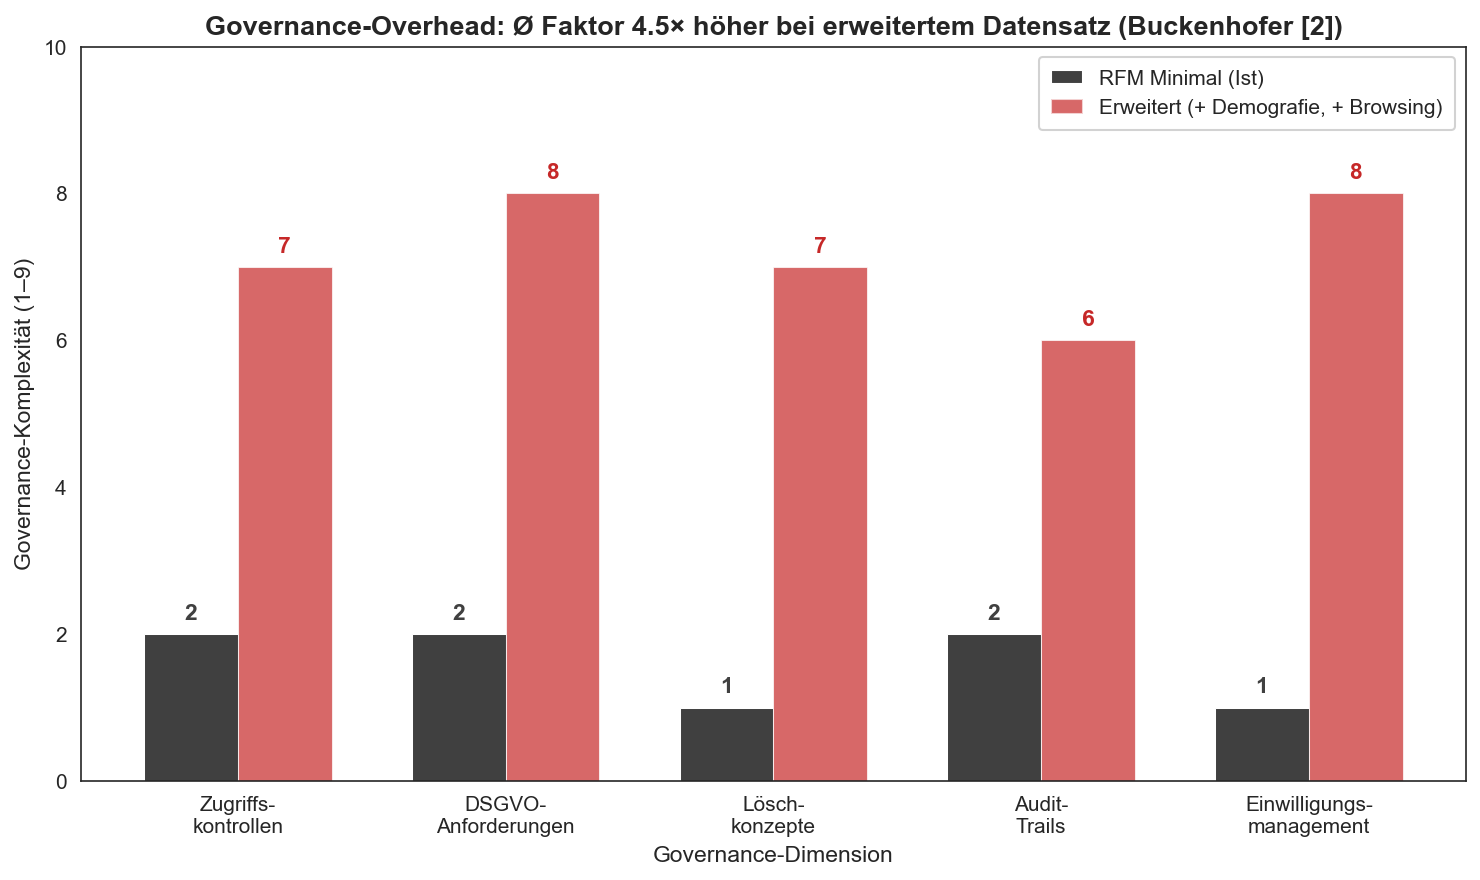

,Governance-Dimension,RFM Minimal,Erweitert,Faktor
1,Zugriffskontrollen,2.0,7.0,3.5×
2,DSGVO-Anforderungen,2.0,8.0,4.0×
3,Löschkonzepte,1.0,7.0,7.0×
4,Audit-Trails,2.0,6.0,3.0×
5,Einwilligungsmanagement,1.0,8.0,8.0×
Ø,Durchschnitt,1.6,7.2,4.5×


In [15]:
# Visualisierung 6: Governance-Overhead Vergleich (IBCS-konform)

# Fünf Governance-Dimensionen nach Buckenhofer [2]
gov_dimensions = ['Zugriffs-\nkontrollen', 'DSGVO-\nAnforderungen', 'Lösch-\nkonzepte', 'Audit-\nTrails', 'Einwilligungs-\nmanagement']

# Qualitative Einschätzung: RFM-Minimal vs. erweiterter Datensatz (1-9)
rfm_minimal = [2, 2, 1, 2, 1]
extended    = [7, 8, 7, 6, 8]

fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(gov_dimensions))
width = 0.35

# Gruppierte Balken: Minimal (dunkelgrau) vs. Erweitert (rot)
bars1 = ax.bar(x - width/2, rfm_minimal, width, color=IBCS['actual'], edgecolor='white', linewidth=0.5)
bars2 = ax.bar(x + width/2, extended, width, color=IBCS['highlight_neg'], alpha=0.7, edgecolor='white', linewidth=0.5)

# Werte über den Balken
for bar in bars1:
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.2, f'{bar.get_height():.0f}', ha='center', fontweight='bold', fontsize=11, color=IBCS['annotation'])
for bar in bars2:
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.2, f'{bar.get_height():.0f}', ha='center', fontweight='bold', fontsize=11, color=IBCS['highlight_neg'])

ax.set_ylabel('Governance-Komplexität (1–9)')
ax.set_xticks(x)
ax.set_xticklabels(gov_dimensions)
ax.set_xlabel('Governance-Dimension')
ax.set_ylim(0, 10)

# Legende
legend_handles = [
    Patch(facecolor=IBCS['actual'], edgecolor='white', label='RFM Minimal (Ist)'),
    Patch(facecolor=IBCS['highlight_neg'], alpha=0.7, edgecolor='white', label='Erweitert (+ Demografie, + Browsing)'),
]
ax.legend(handles=legend_handles, loc='upper right', fontsize=10, frameon=True, facecolor='white', edgecolor='#D0D0D0', framealpha=0.95, borderpad=0.6, handlelength=1.5)

# Gesamtfaktor im Titel
avg_min = np.mean(rfm_minimal)
avg_ext = np.mean(extended)
ax.set_title(f'Governance-Overhead: Ø Faktor {avg_ext/avg_min:.1f}× höher bei erweitertem Datensatz (Buckenhofer [2])')

plt.tight_layout()
plt.show()

# Governance-Vergleich als DataFrame-Tabelle
dim_labels = ['Zugriffskontrollen', 'DSGVO-Anforderungen', 'Löschkonzepte', 'Audit-Trails', 'Einwilligungsmanagement']
df_gov = pd.DataFrame({
    'Governance-Dimension': dim_labels,
    'RFM Minimal': rfm_minimal,
    'Erweitert': extended,
    'Faktor': [e / m for e, m in zip(extended, rfm_minimal)]
})
df_gov.index = range(1, len(df_gov) + 1)
df_gov.loc['Ø'] = ['Durchschnitt', avg_min, avg_ext, avg_ext / avg_min]
df_gov['Faktor'] = df_gov['Faktor'].apply(lambda x: f'{x:.1f}×')
df_gov

---
## 7. Fazit

Drei abgeleitete Kennzahlen (Recency, Frequency, Monetary) reichen aus, um High-Value-Kunden zu identifizieren, Abwanderung zu erkennen und Cross-Selling-Potenziale abzuleiten. Das Ranking-Experiment belegt, dass zusätzliche Features das Kunden-Ranking um weniger als ein Prozent verändern. Der Aufbau eines Datenprodukts sollte daher mit einem klar definierten MVDP beginnen und nur dann erweitert werden, wenn der Zusatznutzen den Aufwand rechtfertigt.

---
## 8. Literaturverzeichnis

[1] Buckenhofer, A. (2025): Data Engineering. Vorlesungsfolien Nr. 03, Kurs WWI2023F „Data Management Fundamentals", DHBW Stuttgart.

[2] Buckenhofer, A. (2025): Data Governance, Rechtlicher Rahmen, Datenschutz, Datensicherheit. Vorlesungsfolien Nr. 08, Kurs WWI2023F „Data Management Fundamentals", DHBW Stuttgart.

[3] Buckenhofer, A. (2025): Spaltenorientierte Datenbanken. Vorlesungsfolien Nr. 04, Kurs WWI2023F „Data Management Fundamentals", DHBW Stuttgart.

[4] Chen, D., Sain, S. L. & Guo, K. (2012): Data mining for the online retail industry: A case study of RFM model-based customer segmentation using data mining. *Journal of Database Marketing & Customer Strategy Management*, 19(3), 197–208.

[5] Dehghani, Z. (2022): *Data Mesh: Delivering Data-Driven Value at Scale.* Sebastopol: O'Reilly Media.

[6] DuckDB Foundation (2025): DuckDB Documentation. Verfügbar unter: https://duckdb.org/docs/ (Zugriff: 10.02.2026).

[7] Fader, P. S. & Hardie, B. G. S. (2009): Probability Models for Customer-Base Analysis. *Journal of Interactive Marketing*, 23(1), 61–69.

[8] Hughes, A. M. (1994): *Strategic Database Marketing.* Chicago: Probus Publishing.

[9] Reichheld, F. F. & Sasser, W. E. (1990): Zero Defections: Quality Comes to Services. *Harvard Business Review*, 68(5), 105–111.

[10] Reis, J. & Housley, M. (2022): *Fundamentals of Data Engineering: Plan and Build Robust Data Systems.* Sebastopol: O'Reilly Media.

[11] Ries, E. (2011): *The Lean Startup: How Today's Entrepreneurs Use Continuous Innovation to Create Radically Successful Businesses.* New York: Crown Business.

[12] UCI Machine Learning Repository (2012): Online Retail Dataset. Lizenz: CC BY 4.0. Verfügbar unter: https://archive.ics.uci.edu/dataset/352/online+retail (Zugriff: 10.02.2026).

---
## Erklärung zur Verwendung generativer KI-Systeme

Bei der Erstellung der eingereichten Arbeit habe ich auf künstlicher Intelligenz (KI) basierte Systeme benutzt:

- ☒ ja
- ☐ nein

Die nachfolgend aufgeführten auf künstlicher Intelligenz (KI) basierten Systeme habe ich bei der Erstellung der eingereichten Arbeit benutzt:

1. Claude (Anthropic)
2. ChatGPT (OpenAI)
3. Gemini (Google)

Ich erkläre, dass ich

- mich aktiv über die Leistungsfähigkeit und Beschränkungen der oben genannten KI-Systeme informiert habe,
- die aus den oben angegebenen KI-Systemen direkt oder sinngemäß übernommenen Passagen gekennzeichnet habe,
- überprüft habe, dass die mithilfe der oben genannten KI-Systeme generierten und von mir übernommenen Inhalte faktisch richtig sind,
- mir bewusst bin, dass ich als Autor dieser Arbeit die Verantwortung für die in ihr gemachten Angaben und Aussagen trage.

Die oben genannten KI-Systeme habe ich wie im Folgenden dargestellt eingesetzt:

| Arbeitsschritt in der wissenschaftlichen Arbeit | Eingesetzte(s) KI-System(e) | Beschreibung der Verwendungsweise |
|---|---|---|
| Code-Optimierung | Claude (Anthropic), Gemini (Google) | Optimierung der Visualisierungen: Pareto-Kurve, Segmentverteilung, Churn-Rate, Ranking-Korrelation, Aufwand-Wert-Matrix und Governance-Overhead-Vergleich sowie des Data-Engineering-Lifecycle-Diagramms |
| Literaturrecherche | Claude (Anthropic), ChatGPT (OpenAI), Gemini (Google) | Verschaffung eines Überblicks über relevante Fachliteratur und Identifikation geeigneter Quellen |

Die inhaltliche Konzeption, die kritische Analyse und die Einordnung in den Vorlesungskontext erfolgten eigenständig. Alle Ergebnisse wurden am realen UCI-Datensatz verifiziert und sind reproduzierbar.

---
## Eigenständigkeitserklärung

Ich versichere hiermit, dass ich die vorliegende Arbeit mit dem Thema: Daten als Produkt: Wert vs. Aufwand selbstständig verfasst und keine anderen als die angegebenen Quellen und Hilfsmittel benutzt habe.